In [38]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio

from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
meta = pd.read_csv('../../training.csv')
test_meta = pd.read_csv('../../test.csv')

## time

In [3]:
train_times = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    train_times.append(len(y)/ sr)
train_times = pd.Series(train_times)
train_times.describe()

count    2700.000000
mean        0.438810
std         0.149941
min         0.143537
25%         0.342268
50%         0.420590
75%         0.512653
max         2.282766
dtype: float64

<AxesSubplot:>

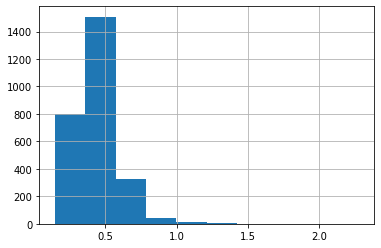

In [4]:
train_times.hist()

In [5]:
t = [item for item in train_times if item <= 1.0]
len(t)

2682

In [6]:
test_times = []
for name in test_meta['path']:
    y, sr = librosa.load('../../' + name)
    test_times.append(len(y)/ sr)
test_times = pd.Series(test_times)
test_times.describe()

count    300.000000
mean       0.425273
std        0.124639
min        0.195011
25%        0.342914
50%        0.410590
75%        0.493934
max        1.038639
dtype: float64

<AxesSubplot:>

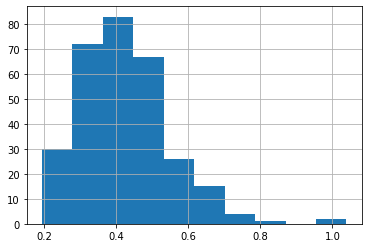

In [7]:
test_times.hist()

In [8]:
t = [item for item in test_times if item <= 1.0]
len(t)

298

In [9]:
long_audio_idxes = [i for i in range(len(train_times)) if train_times[i] > 1.0]
len(long_audio_idxes)

18

In [10]:
# for idx in long_audio_idxes:
#     y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
#     ipd.display(Audio(y, rate=sr))

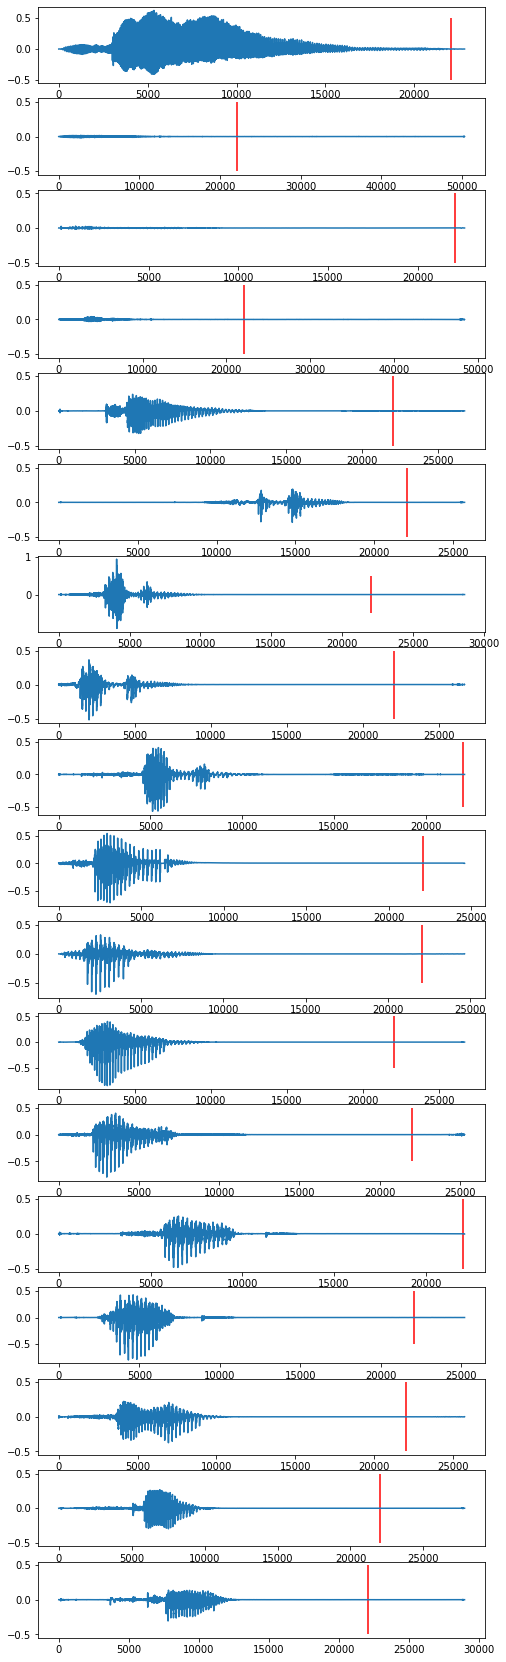

In [11]:
fig, axes = plt.subplots(len(long_audio_idxes), figsize=(8,30))
for i, idx in enumerate(long_audio_idxes):
    y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
    axes[i].plot(y)
    axes[i].vlines([sr], -0.5, 0.5, "red")

In [12]:
# # make new meta
# # meta = pd.read_csv('../training.csv')
# name_list = []
# label_list = []
# for i in range(len(meta)):
#     if train_times[i] <= 1.0:
#         name_list.append(meta['path'][i])
#         label_list.append(meta['label'][i])
# new_meta = pd.DataFrame(list(zip(name_list, label_list)), columns=['path', 'label'])
# # new_meta.to_csv('../new_training.csv', index=False)

In [13]:
# # make new meta
# name_list = []
# for i in range(len(test_meta)):
#     if test_times[i] <= 1.0:
#         name_list.append(test_meta['path'][i])
# df = pd.DataFrame(name_list, columns=['path'])
# df.to_csv('../new_test.csv', index=False)

### relation of number and audio time

In [14]:
meta['times'] = train_times
meta.head()

,path,label,times
0,dataset/train/jackson_0.wav,4,0.502902
1,dataset/train/jackson_1.wav,4,0.429252
2,dataset/train/jackson_2.wav,4,0.484898
3,dataset/train/jackson_3.wav,4,0.440272
4,dataset/train/jackson_4.wav,4,0.454512


In [15]:
meta.groupby('label').describe()['times']

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,270.0,0.503607,0.126826,0.271791,0.405850,0.487528,0.591735,1.167664
1,270.0,0.403095,0.127845,0.174875,0.306757,0.377778,0.482551,0.941542
2,270.0,0.385760,0.140438,0.161043,0.288379,0.356576,0.471168,1.213379
3,270.0,0.402025,0.154027,0.181905,0.284966,0.381655,0.496814,1.313016
4,270.0,0.409257,0.111757,0.169887,0.331179,0.397642,0.470329,1.114875
5,270.0,0.453843,0.120902,0.209161,0.378061,0.424580,0.512619,1.147256
6,270.0,0.453374,0.182824,0.143537,0.319002,0.444195,0.569875,0.977506
7,270.0,0.461145,0.178380,0.245669,0.367370,0.438753,0.507336,2.195918
8,270.0,0.415019,0.119294,0.218639,0.342857,0.400703,0.467268,1.142902


## Baseline extract features

In [16]:
def feature_extraction(path_list):
    """
    wavファイルのリストから特徴抽出を行い，リストで返す
    扱う特徴量はMFCC13次元の平均（0次は含めない）
    Args:
        path_list: 特徴抽出するファイルのパスリスト
    Returns:
        features: 特徴量
    """

    load_data = (lambda path: librosa.load('../../' + path)[0])

    data = list(map(load_data, path_list))
    features = np.array([np.mean(librosa.feature.mfcc(y=y, n_mfcc=13), axis=1) for y in data])

    return features

In [17]:
# features = feature_extraction(list(meta['path']))
# features.shape

## kfold

<AxesSubplot:>

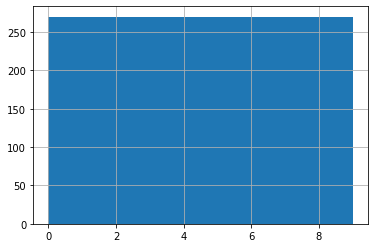

In [18]:
meta['label'].hist()

In [19]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [20]:
# n_splits = 3
# idxes = [i for i in range(len(meta))]
# X = idxes
# y = meta['label'].values

# fig, ax = plt.subplots()
# cv = KFold(n_splits)

# plot_cv_indices(cv, X, y, ax, n_splits)

In [21]:
# fig, ax = plt.subplots()
# skf = StratifiedKFold(n_splits)
# plot_cv_indices(skf, X, y, ax, n_splits)

In [22]:
n_splits = 3
idxes = [i for i in range(len(meta))]
labels = meta['label'].values
cv = KFold(n_splits)

fold_tr_labels = {}
fold_val_labels = {}
for i, (tr_idx, val_idx) in enumerate(cv.split(idxes)):
    fold_tr_labels[str(i)] = labels[tr_idx]
    fold_val_labels[str(i)] = labels[val_idx]

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

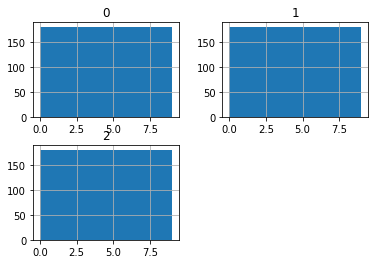

In [23]:
pd.DataFrame(fold_tr_labels).hist()

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

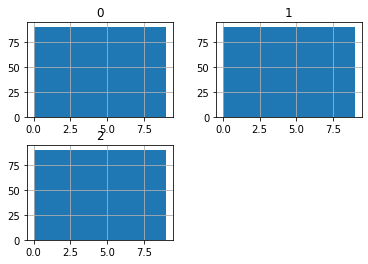

In [24]:
pd.DataFrame(fold_val_labels).hist()

## mel spectrogram

In [25]:
def mel_spec(input: np.ndarray, sr: int, win_size: int, hop_len: int, n_mels: int) -> np.ndarray:
    # spec = librosa.stft(
    #     y=input, n_fft=win_size, win_length=win_size, hop_length=hop_len)
    # spec = np.abs(spec) ** 2.0

    # mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=win_size, n_mels=n_mels)
    # mel = np.dot(mel_filter_bank, spec)

    mel = librosa.feature.melspectrogram(
        y=input, sr=sr, n_mels=n_mels, n_fft=win_size, win_length=win_size, hop_length=hop_len)
    log_mel = librosa.amplitude_to_db(mel)

    return log_mel

In [26]:
y, sr = librosa.load('../../' + meta['path'].loc[456])
Audio(y, rate=sr)

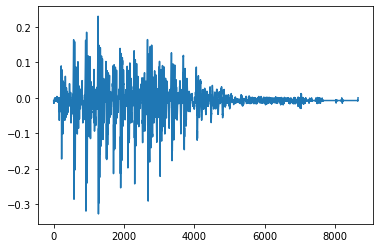

In [27]:
plt.plot(y)

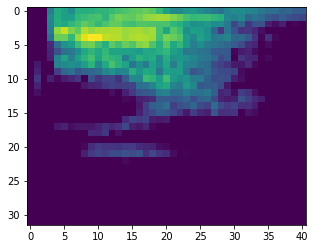

In [88]:
win_size = int(sr*0.025)
overlap = 0.5
n_mels = 32

logmel = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
logmel = np.float32(logmel[:, :])
plt.imshow(logmel)

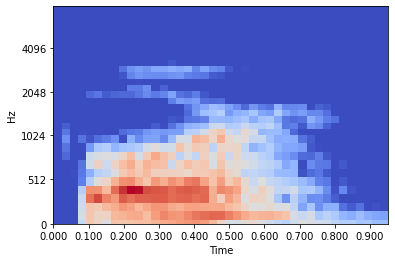

In [89]:
librosa.display.specshow(logmel, x_axis='time', y_axis='mel', sr=sr, fmax=8000)

## db

In [53]:
train_max_dbs = []
train_min_dbs = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    train_max_dbs.append(y.max())
    train_min_dbs.append(y.min())
train_dbs = pd.DataFrame(list(zip(train_min_dbs, train_max_dbs)), columns=['min', 'max'])
train_dbs.describe()

,min,max
count,2700.000000,2700.000000
mean,-0.279941,0.223887
std,0.212060,0.172017
min,-1.012407,0.008771
25%,-0.415466,0.054367
50%,-0.268997,0.213309
75%,-0.075002,0.332886
max,-0.009601,1.040595


<AxesSubplot:xlabel='min', ylabel='max'>

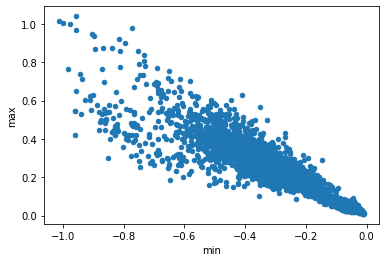

In [54]:
train_dbs.plot.scatter(x='min', y='max')

In [55]:
test_max_dbs = []
test_min_dbs = []
for name in test_meta['path']:
    y, sr = librosa.load('../../' + name)
    test_max_dbs.append(y.max())
    test_min_dbs.append(y.min())
test_dbs = pd.DataFrame(list(zip(test_min_dbs, test_max_dbs)), columns=['min', 'max'])
test_dbs.describe()

,min,max
count,300.000000,300.000000
mean,-0.287640,0.227697
std,0.220482,0.177917
min,-0.958323,0.014299
25%,-0.423605,0.055603
50%,-0.266880,0.212667
75%,-0.076413,0.335312
max,-0.012448,1.006432


<AxesSubplot:xlabel='min', ylabel='max'>

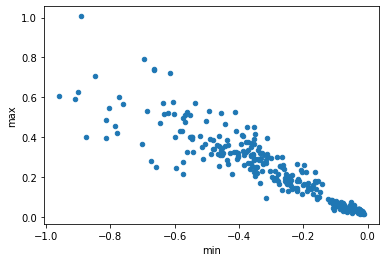

In [56]:
test_dbs.plot.scatter(x='min', y='max')

## SpecAugmentation

In [57]:
import torch
from torchlibrosa.augmentation import SpecAugmentation

Text(0.5, 1.0, 'SpecAug')

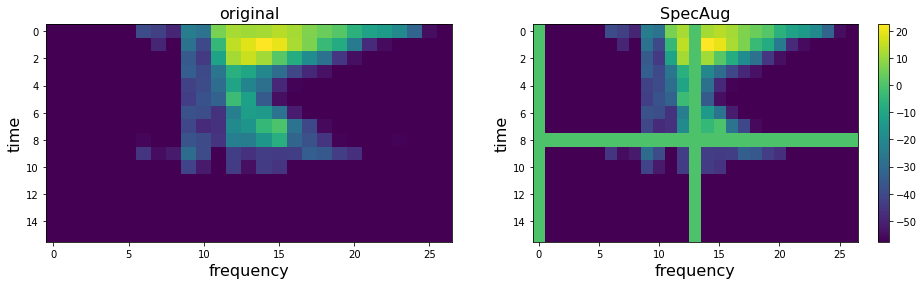

In [58]:
spec_augmenter = SpecAugmentation(
    time_drop_width=2, time_stripes_num=2, freq_drop_width=2, freq_stripes_num=2
)

win_size = int(sr*0.05)
overlap = 0.5
n_mels = 16
logmel = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
logmel_ch = np.float32(logmel[np.newaxis, :, :])
logmel_tensor = torch.tensor(logmel_ch).unsqueeze(0)

augmented = spec_augmenter(logmel_tensor)
augmented = augmented.squeeze(0).squeeze(0).numpy()

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.imshow(logmel, aspect="auto")
plt.xlabel("frequency", size=16)
plt.ylabel("time", size=16)
plt.title("original", size=16)
plt.subplot(1, 2, 2)
plt.imshow(augmented, aspect="auto")
plt.colorbar()
plt.xlabel("frequency", size=16)
plt.ylabel("time", size=16)
plt.title("SpecAug", size=16)

## Augmentation

### add gaussian noise

In [59]:
def add_gaussian_noise(input, max_noise_amplitude=0.1):
    noise_amplitude = np.random.uniform(0.0, max_noise_amplitude)
    noise = np.random.randn(len(input))
    augmented = (input + noise * noise_amplitude).astype(input.dtype)
    
    return augmented

In [60]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = add_gaussian_noise(y)
Audio(y_augmented, rate=sr)

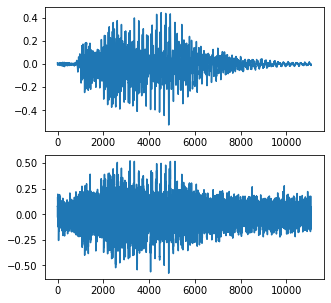

In [61]:
plt.figure(figsize=(5, 5))

plt.subplot(2,1,1)
plt.plot(y)

plt.subplot(2,1,2)
plt.plot(y_augmented)

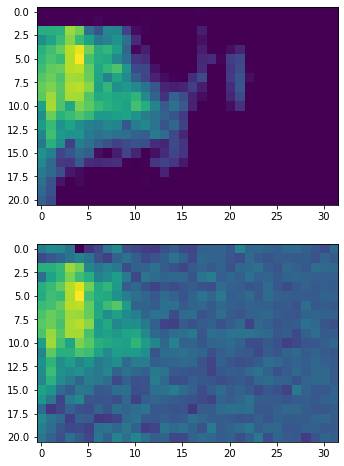

In [62]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

plt.subplot(2,1,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

### gaussian noise SNR

In [63]:
def gaussian_noise_snr(input, min_snr=5.0, max_snr=20.0):
    snr = np.random.uniform(min_snr, max_snr)
    a_signal = np.sqrt(input ** 2).max()
    a_noise = a_signal / (10 ** (snr / 20))
    
    white_noise = np.random.randn(len(input))
    a_white = np.sqrt(white_noise ** 2).max()
    augmented = (input + white_noise * 1 / a_white * a_noise).astype(y.dtype)
    
    return augmented

In [64]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = gaussian_noise_snr(y)
Audio(y_augmented, rate=sr)

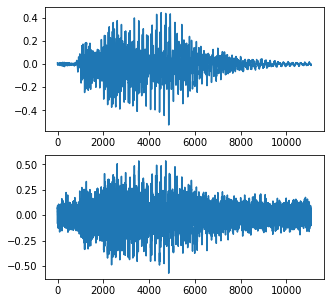

In [65]:
plt.figure(figsize=(5, 5))

plt.subplot(2,1,1)
plt.plot(y)

plt.subplot(2,1,2)
plt.plot(y_augmented)

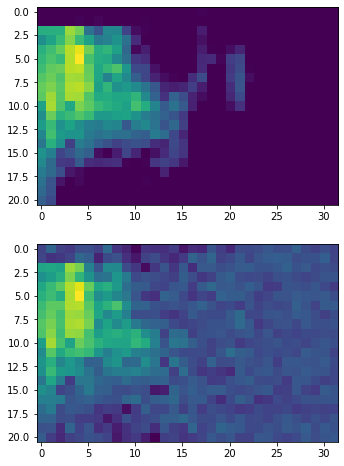

In [66]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

plt.subplot(2,1,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

### Time Shift

In [67]:
def time_shift(input, sr, max_shift_second=0.2, padding_mode='replace'):
    shift = np.random.randint(-sr*max_shift_second, sr*max_shift_second)
    augmented = np.roll(input, shift)
    if padding_mode == "zero":
        if shift > 0:
            augmented[:shift] = 0
        else:
            augmented[shift:] = 0
    return augmented

In [68]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = time_shift(y, sr)
Audio(y_augmented, rate=sr)

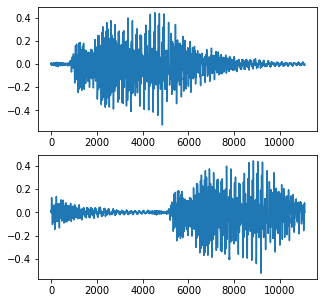

In [69]:
plt.figure(figsize=(5, 5))

plt.subplot(2,1,1)
plt.plot(y)

plt.subplot(2,1,2)
plt.plot(y_augmented)

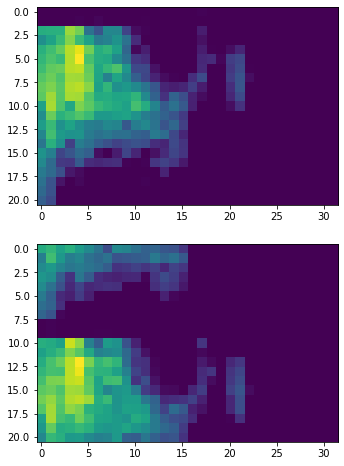

In [70]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

plt.subplot(2,1,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

### Volume Controll

In [90]:
def volume_control(input, db_lim=20, mode='sine'):
    """
    mode must be one of 'uniform', 'fade', 'cosine', 'sine'
    """

    db = np.random.uniform(-db_lim, db_lim)
    if mode == "uniform":
        db_translated = 10 ** (db / 20)
    elif mode == "fade":
        lin = np.arange(len(input))[::-1] / (len(input) - 1)
        db_translated = 10 ** (db * lin / 20)
    elif mode == "cosine":
        cosine = np.cos(np.arange(len(input)) / len(input) * np.pi * 2)
        db_translated = 10 ** (db * cosine / 20)
    else:
        sine = np.sin(np.arange(len(input)) / len(input) * np.pi * 2)
        db_translated = 10 ** (db * sine / 20)

    augmented = input * db_translated
    
    return augmented

In [91]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = volume_control(y)
Audio(y_augmented, rate=sr)

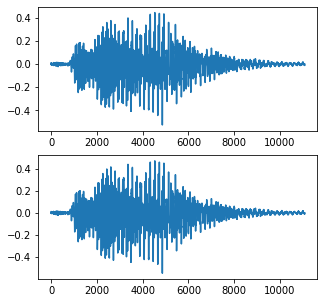

In [84]:
plt.figure(figsize=(5, 5))

plt.subplot(2,1,1)
plt.plot(y)

plt.subplot(2,1,2)
plt.plot(y_augmented)

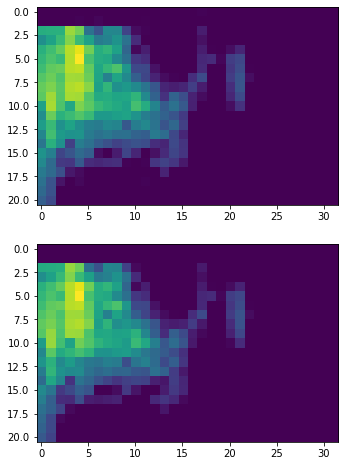

In [85]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)

plt.subplot(2,1,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)